## Install the package dependencies before running this notebook

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import os, os.path 
import numpy as np
import pickle
from glob import glob
import pickle
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
import pandas as pd

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [2]:
ROOT_PATH = "./argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    f_in = ROOT_PATH + split + "/" + city + "_inputs"
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    
    outputs = None
    
    if split=="train":
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city:str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform
        self.city = city
        self.split = split

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        
#         print(type(self.inputs))
#         print(type(self.outputs))
        
        if self.split == 'train':
            data = (torch.from_numpy(self.inputs[idx]).float(), torch.from_numpy(self.outputs[idx]).float())
        else:
            data = (torch.from_numpy(self.inputs[idx]).float())
#         print(type(data[0]))
#         print(type(data[1]))
            
        if self.transform:
            data = self.transform(data)

        return data


# intialize a dataset
city = 'palo-alto' 
split = 'train'
train_dataset = ArgoverseDataset(city = city, split = split)

# Exploratory Analysis

In [3]:
# initialize datasets

train_datasets = []
test_datasets = []

for city in cities:
    train_dataset = ArgoverseDataset(city=city, split='train')
    test_dataset = ArgoverseDataset(city=city, split='test')
    
    train_datasets.append(train_dataset)
    test_datasets.append(test_dataset)
    
for train in train_datasets:
    print(f'{train.city}: {train.inputs.shape}')

austin: (43041, 50, 2)
miami: (55029, 50, 2)
pittsburgh: (43544, 50, 2)
dearborn: (24465, 50, 2)
washington-dc: (25744, 50, 2)
palo-alto: (11993, 50, 2)


aggregate stats:
min x1: -5032.128190481392, max x1: 2234.1020005405303
min y1: -2575.73710565541, max y1: 3773.5724851573327
min x2: -5056.2509476956575, max x2: 2233.6892871811247
min y2: -2584.137453651663, max y2: 3755.651010835162


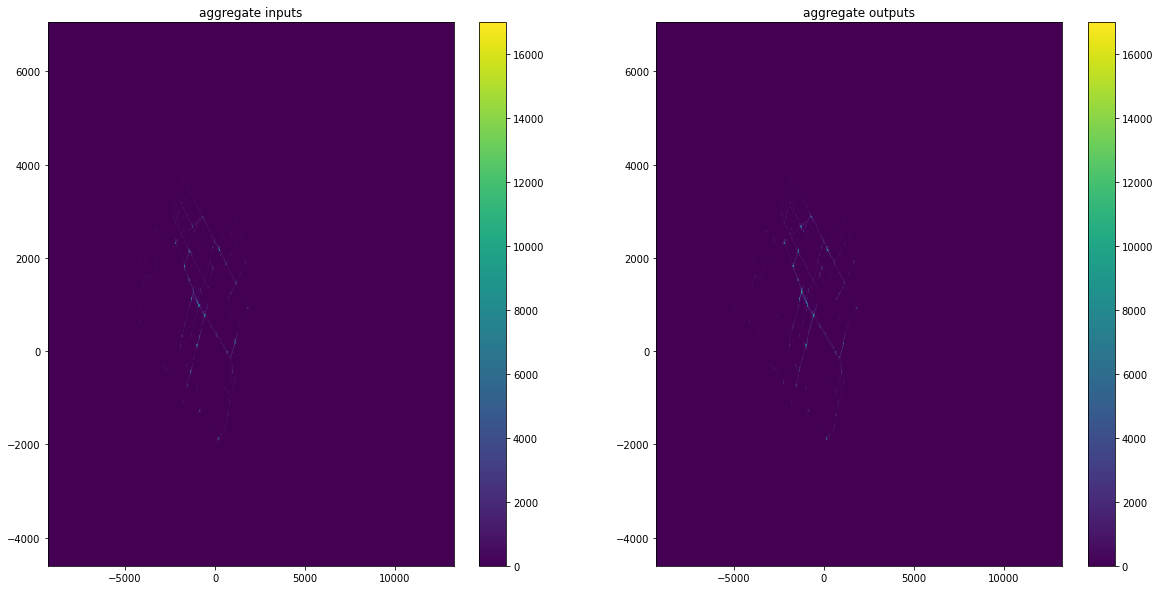

In [4]:
x1 = []
y1 = []
for i in range(train_dataset.inputs.shape[1]):
    curr = train_dataset.inputs[:,i,:]
    x1 += list(curr[:,0])
    y1 += list(curr[:,1])
fig8 = plt.figure(figsize=(20,10))
ax1 = fig8.add_subplot(121)
counts, xedges, yedges, im = ax1.hist2d(x1, y1, bins=[np.arange(-9300,13300,50),np.arange(-4600,7100,50)],
                                       vmin=0, vmax=17000)
fig8.colorbar(im, ax=ax1)
ax1.set_title("aggregate inputs")

x2 = []
y2 = []
for i in range(train_dataset.outputs.shape[1]):
    curr = train_dataset.outputs[:,i,:]
    x2 += list(curr[:,0])
    y2 += list(curr[:,1])
ax2 = fig8.add_subplot(122)
counts, xedges, yedges, im = ax2.hist2d(x2, y2, bins=[np.arange(-9300,13300,50),np.arange(-4600,7100,50)],
                                       vmin=0, vmax=17000)
fig8.colorbar(im, ax=ax2)
ax2.set_title("aggregate outputs")

print(f'aggregate stats:')
print(f'min x1: {min(x1)}, max x1: {max(x1)}')
print(f'min y1: {min(y1)}, max y1: {max(y1)}')
print(f'min x2: {min(x2)}, max x2: {max(x2)}')
print(f'min y2: {min(y2)}, max y2: {max(y2)}')

austin stats:
min x1: -2754.1364660823856, max x1: 4241.488092484203
min y1: -4211.255435808992, max y1: 3133.064101216354
min x2: -2751.731376460925, max x1: 4212.124011297809
min y2: -4204.383097720112, max y1: 3176.8867140461452


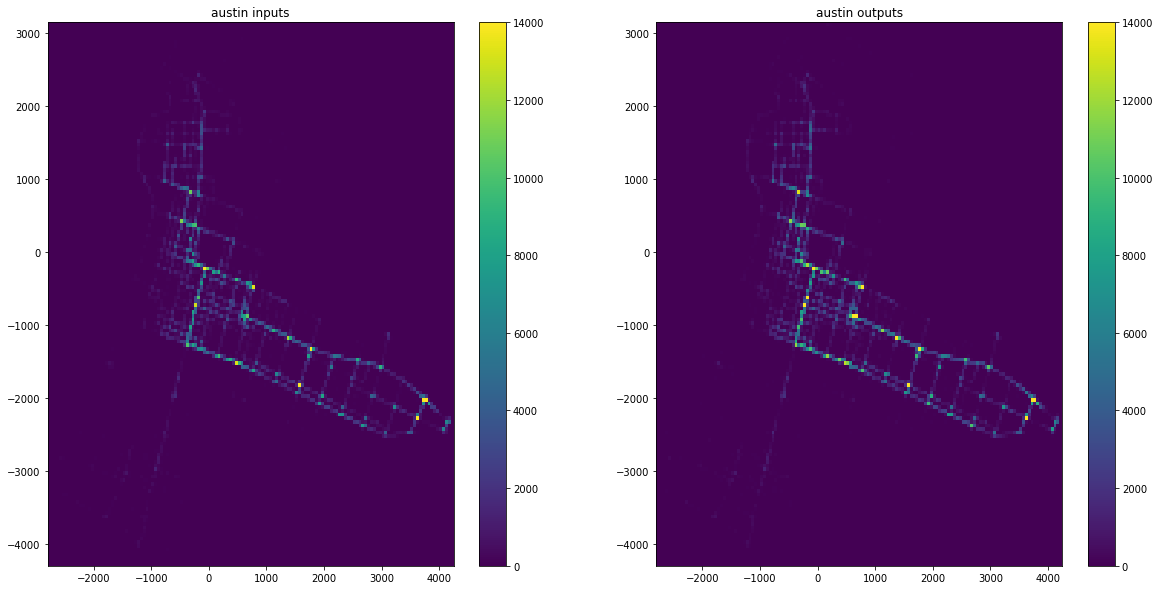

In [4]:
x1 = []
y1 = []
for i in range(train_datasets[0].inputs.shape[1]):
    curr = train_datasets[0].inputs[:,i,:]
    x1 += list(curr[:,0])
    y1 += list(curr[:,1])
fig1 = plt.figure(figsize=(20,10))
ax1 = fig1.add_subplot(121)
counts, xedges, yedges, im = ax1.hist2d(x1, y1, bins=[np.arange(-2800,4300,50),np.arange(-4300,3200,50)],
                                        vmin=0, vmax=14000)
ax1.set_title("austin inputs")
fig1.colorbar(im, ax=ax1)

x2 = []
y2 = []
for i in range(train_datasets[0].outputs.shape[1]):
    curr = train_datasets[0].outputs[:,i,:]
    x2 += list(curr[:,0])
    y2 += list(curr[:,1])
ax2 = fig1.add_subplot(122)
counts, xedges, yedges, im = ax2.hist2d(x2, y2, bins=[np.arange(-2800,4300,50),np.arange(-4300,3200,50)],
                                       vmin=0, vmax=14000)
ax2.set_title("austin outputs")
fig1.colorbar(im, ax=ax2)

print(f'austin stats:')
print(f'min x1: {min(x1)}, max x1: {max(x1)}')
print(f'min y1: {min(y1)}, max y1: {max(y1)}')
print(f'min x2: {min(x2)}, max x1: {max(x2)}')
print(f'min y2: {min(y2)}, max y1: {max(y2)}')

miami stats:
min x1: -9222.61470641863, max x1: 7315.477589872011
min y1: -4535.476698992521, max y1: 5311.323608033551
min x2: -9231.75573256512, max x2: 7321.264226843908
min y2: -4539.313391138148, max y2: 5312.344976073972


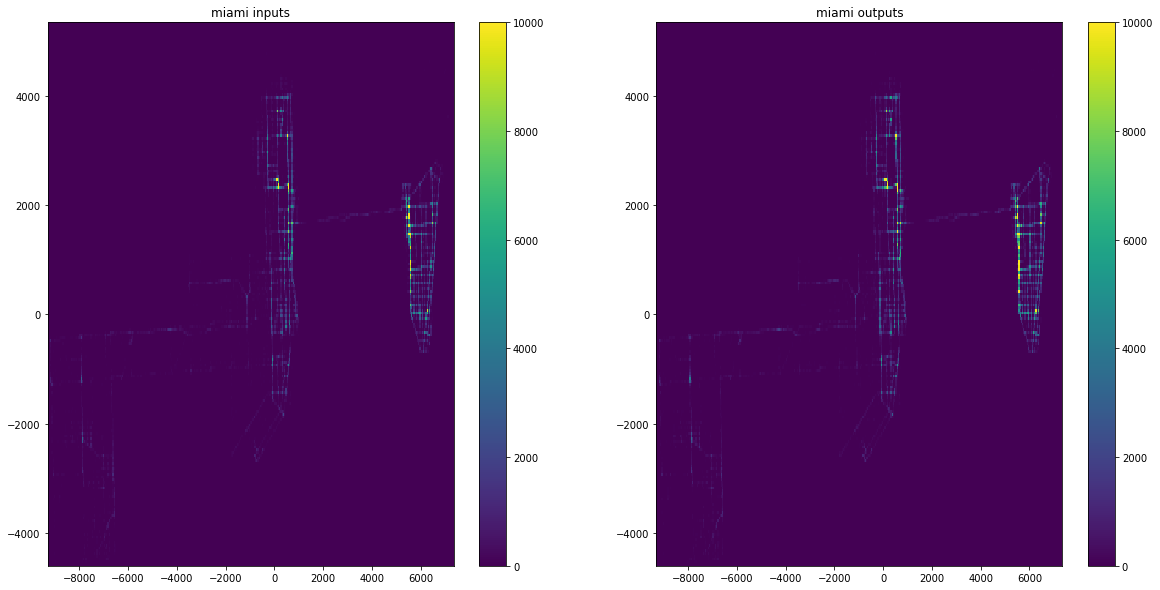

In [5]:
x1 = []
y1 = []
for i in range(train_datasets[1].inputs.shape[1]):
    curr = train_datasets[1].inputs[:,i,:]
    x1 += list(curr[:,0])
    y1 += list(curr[:,1])
fig2 = plt.figure(figsize=(20,10))
ax1 = fig2.add_subplot(121)
counts, xedges, yedges, im = ax1.hist2d(x1, y1, bins=[np.arange(-9300,7400,50),np.arange(-4600,5400,50)],
                                       vmin=0, vmax=10000)
fig1.colorbar(im, ax=ax1)
ax1.set_title("miami inputs")

x2 = []
y2 = []
for i in range(train_datasets[1].outputs.shape[1]):
    curr = train_datasets[1].outputs[:,i,:]
    x2 += list(curr[:,0])
    y2 += list(curr[:,1])
ax2 = fig2.add_subplot(122)
counts, xedges, yedges, im = ax2.hist2d(x2, y2, bins=[np.arange(-9300,7400,50),np.arange(-4600,5400,50)],
                                       vmin=0, vmax=10000)
fig1.colorbar(im, ax=ax2)
ax2.set_title("miami outputs")

print(f'miami stats:')
print(f'min x1: {min(x1)}, max x1: {max(x1)}')
print(f'min y1: {min(y1)}, max y1: {max(y1)}')
print(f'min x2: {min(x2)}, max x2: {max(x2)}')
print(f'min y2: {min(y2)}, max y2: {max(y2)}')

pittsburgh stats:
min x1: 470.0385747929399, max x1: 8027.560224965913
min y1: -1824.8781533993258, max y1: 3623.293190269404
min x2: 435.3312424305216, max x2: 7998.166750186447
min y2: -1826.5365824864757, max y2: 3609.5550921196677


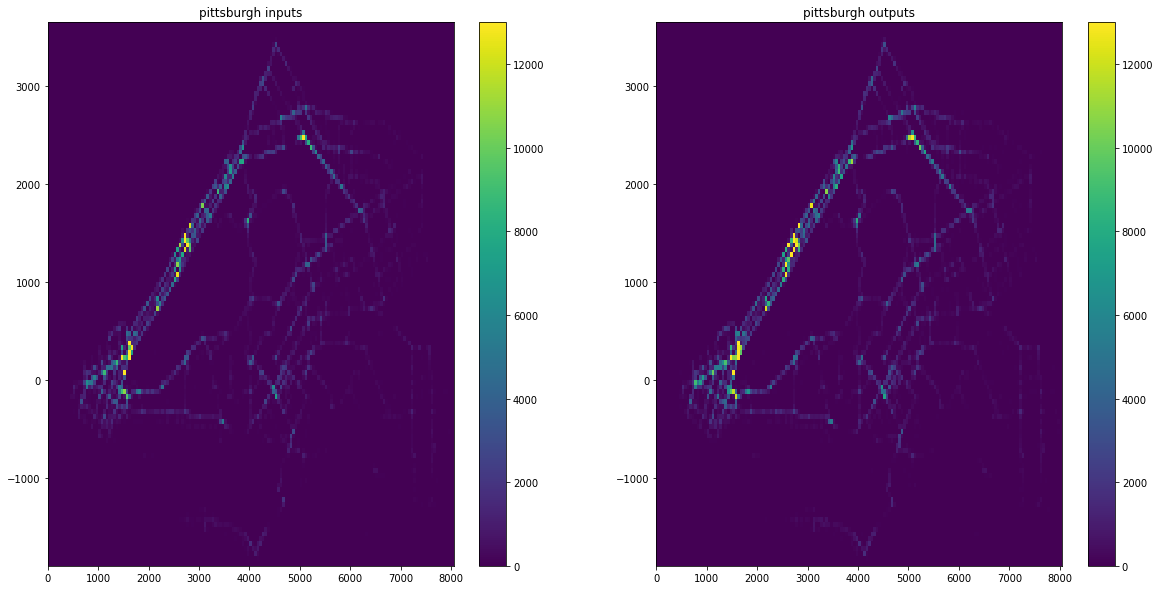

In [6]:
x1 = []
y1 = []
for i in range(train_datasets[2].inputs.shape[1]):
    curr = train_datasets[2].inputs[:,i,:]
    x1 += list(curr[:,0])
    y1 += list(curr[:,1])
fig3 = plt.figure(figsize=(20,10))
ax1 = fig3.add_subplot(121)
counts, xedges, yedges, im = ax1.hist2d(x1, y1, bins=[np.arange(0,8100,50),np.arange(-1900,3700,50)],
                                       vmin=0, vmax=13000)
fig3.colorbar(im, ax=ax1)
ax1.set_title("pittsburgh inputs")

x2 = []
y2 = []
for i in range(train_datasets[2].outputs.shape[1]):
    curr = train_datasets[2].outputs[:,i,:]
    x2 += list(curr[:,0])
    y2 += list(curr[:,1])
ax2 = fig3.add_subplot(122)
counts, xedges, yedges, im = ax2.hist2d(x2, y2, bins=[np.arange(0,8100,50),np.arange(-1900,3700,50)],
                                       vmin=0, vmax=13000)
fig3.colorbar(im, ax=ax2)
ax2.set_title("pittsburgh outputs")

print(f'pittsburgh stats:')
print(f'min x1: {min(x1)}, max x1: {max(x1)}')
print(f'min y1: {min(y1)}, max y1: {max(y1)}')
print(f'min x2: {min(x2)}, max x2: {max(x2)}')
print(f'min y2: {min(y2)}, max y2: {max(y2)}')

dearborn stats:
min x1: -6052.987510579862, max x1: 13295.106948135915
min y1: -775.5496515681594, max y1: 7098.011178254607
min x2: -6023.666045042145, max x2: 13318.46759457012
min y2: -805.0999942882692, max y2: 7048.918470569207


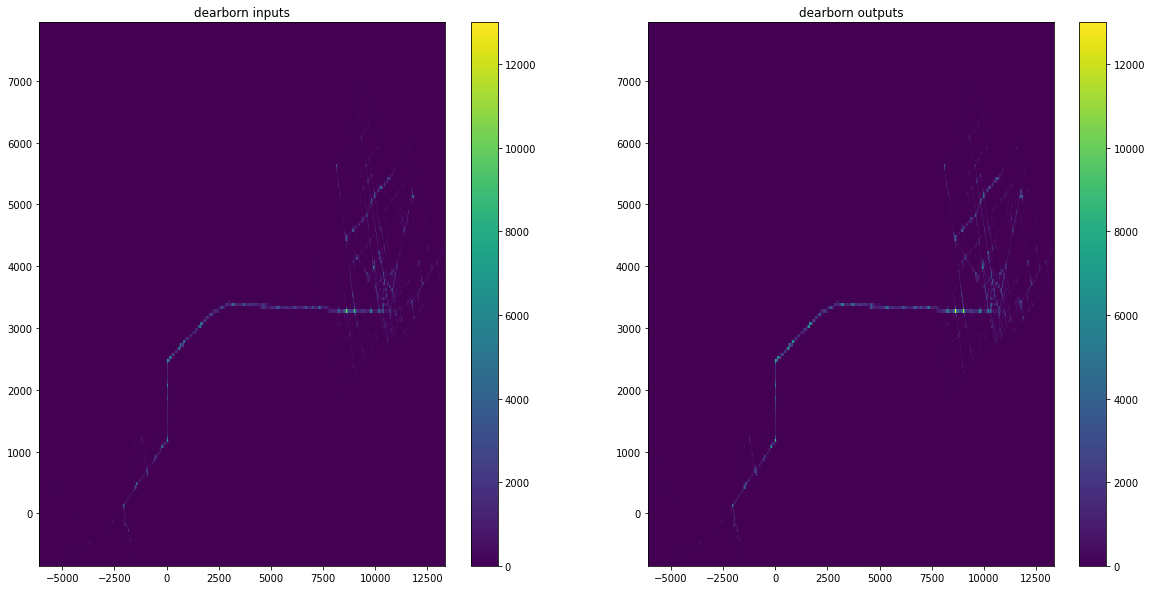

In [10]:
x1 = []
y1 = []
for i in range(train_datasets[3].inputs.shape[1]):
    curr = train_datasets[3].inputs[:,i,:]
    x1 += list(curr[:,0])
    y1 += list(curr[:,1])
fig4 = plt.figure(figsize=(20,10))
ax1 = fig4.add_subplot(121)
counts, xedges, yedges, im = ax1.hist2d(x1, y1, bins=[np.arange(-6100,13400,50),np.arange(-850,8000,50)],
                                       vmin=0, vmax=13000)
fig4.colorbar(im, ax=ax1)
ax1.set_title("dearborn inputs")

x2 = []
y2 = []
for i in range(train_datasets[3].outputs.shape[1]):
    curr = train_datasets[3].outputs[:,i,:]
    x2 += list(curr[:,0])
    y2 += list(curr[:,1])
ax2 = fig4.add_subplot(122)
counts, xedges, yedges, im = ax2.hist2d(x2, y2, bins=[np.arange(-6100,13400,50),np.arange(-850,8000,50)],
                                       vmin=0, vmax=13000)
fig4.colorbar(im, ax=ax2)
ax2.set_title("dearborn outputs")

print(f'dearborn stats:')
print(f'min x1: {min(x1)}, max x1: {max(x1)}')
print(f'min y1: {min(y1)}, max y1: {max(y1)}')
print(f'min x2: {min(x2)}, max x2: {max(x2)}')
print(f'min y2: {min(y2)}, max y2: {max(y2)}')

washington-dc stats:
min x1: 301.94388927146895, max x1: 6985.247910537663
min y1: -1239.0390667058505, max y1: 5638.251211036229
min x2: 275.6506963245901, max x2: 6987.343566945223
min y2: -1232.9342389600067, max y2: 5689.173968560887


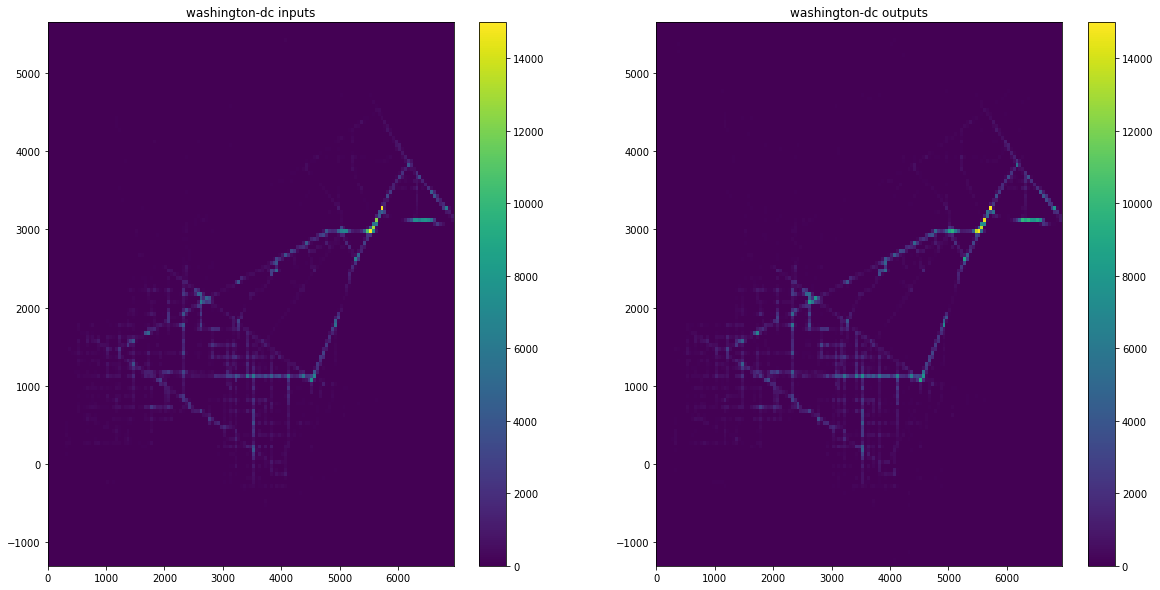

In [11]:
x1 = []
y1 = []
for i in range(train_datasets[4].inputs.shape[1]):
    curr = train_datasets[4].inputs[:,i,:]
    x1 += list(curr[:,0])
    y1 += list(curr[:,1])
fig5 = plt.figure(figsize=(20,10))
ax9 = fig5.add_subplot(121)
counts, xedges, yedges, im = ax9.hist2d(x1, y1, bins=[np.arange(0,7000,50),np.arange(-1300,5700,50)],
                                       vmin=0, vmax=15000)
fig5.colorbar(im, ax=ax9)
ax9.set_title("washington-dc inputs")

x2 = []
y2 = []
for i in range(train_datasets[4].outputs.shape[1]):
    curr = train_datasets[4].outputs[:,i,:]
    x2 += list(curr[:,0])
    y2 += list(curr[:,1])
ax10 = fig5.add_subplot(122)
counts, xedges, yedges, im = ax10.hist2d(x2, y2, bins=[np.arange(0,7000,50),np.arange(-1300,5700,50)],
                                       vmin=0, vmax=15000)
fig5.colorbar(im, ax=ax10)
ax10.set_title("washington-dc outputs")

print(f'washington-dc stats:')
print(f'min x1: {min(x1)}, max x1: {max(x1)}')
print(f'min y1: {min(y1)}, max y1: {max(y1)}')
print(f'min x2: {min(x2)}, max x2: {max(x2)}')
print(f'min y2: {min(y2)}, max y2: {max(y2)}')

palo-alto stats:
min x1: -5032.128190481392, max x1: 2234.1020005405303
min y1: -2575.73710565541, max y1: 3773.5724851573327
min x2: -5056.2509476956575, max x2: 2233.6892871811247
min y2: -2584.137453651663, max y2: 3755.651010835162


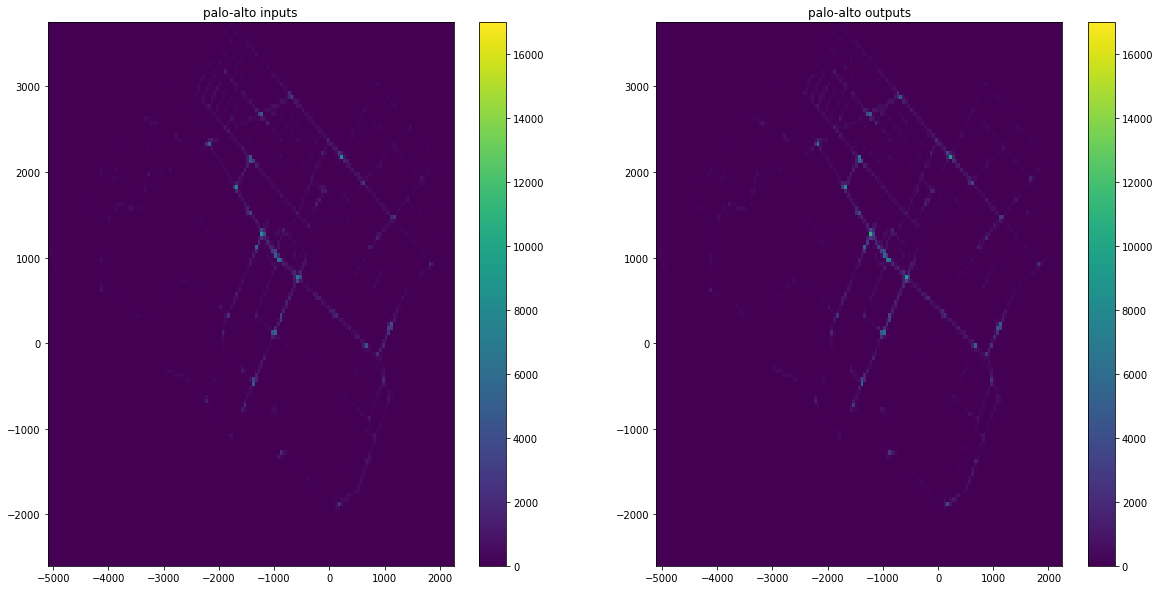

In [12]:
x1 = []
y1 = []
for i in range(train_datasets[5].inputs.shape[1]):
    curr = train_datasets[5].inputs[:,i,:]
    x1 += list(curr[:,0])
    y1 += list(curr[:,1])
fig6 = plt.figure(figsize=(20,10))
ax1 = fig6.add_subplot(121)
counts, xedges, yedges, im = ax1.hist2d(x1, y1, bins=[np.arange(-5100,2300,50),np.arange(-2600,3800,50)],
                                       vmin=0, vmax=17000)
fig6.colorbar(im, ax=ax1)
ax1.set_title("palo-alto inputs")

x2 = []
y2 = []
for i in range(train_datasets[5].outputs.shape[1]):
    curr = train_datasets[5].outputs[:,i,:]
    x2 += list(curr[:,0])
    y2 += list(curr[:,1])
ax2 = fig6.add_subplot(122)
counts, xedges, yedges, im = ax2.hist2d(x2, y2, bins=[np.arange(-5100,2300,50),np.arange(-2600,3800,50)],
                                       vmin=0, vmax=17000)
fig6.colorbar(im, ax=ax2)
ax2.set_title("palo-alto outputs")

print(f'palo-alto stats:')
print(f'min x1: {min(x1)}, max x1: {max(x1)}')
print(f'min y1: {min(y1)}, max y1: {max(y1)}')
print(f'min x2: {min(x2)}, max x2: {max(x2)}')
print(f'min y2: {min(y2)}, max y2: {max(y2)}')

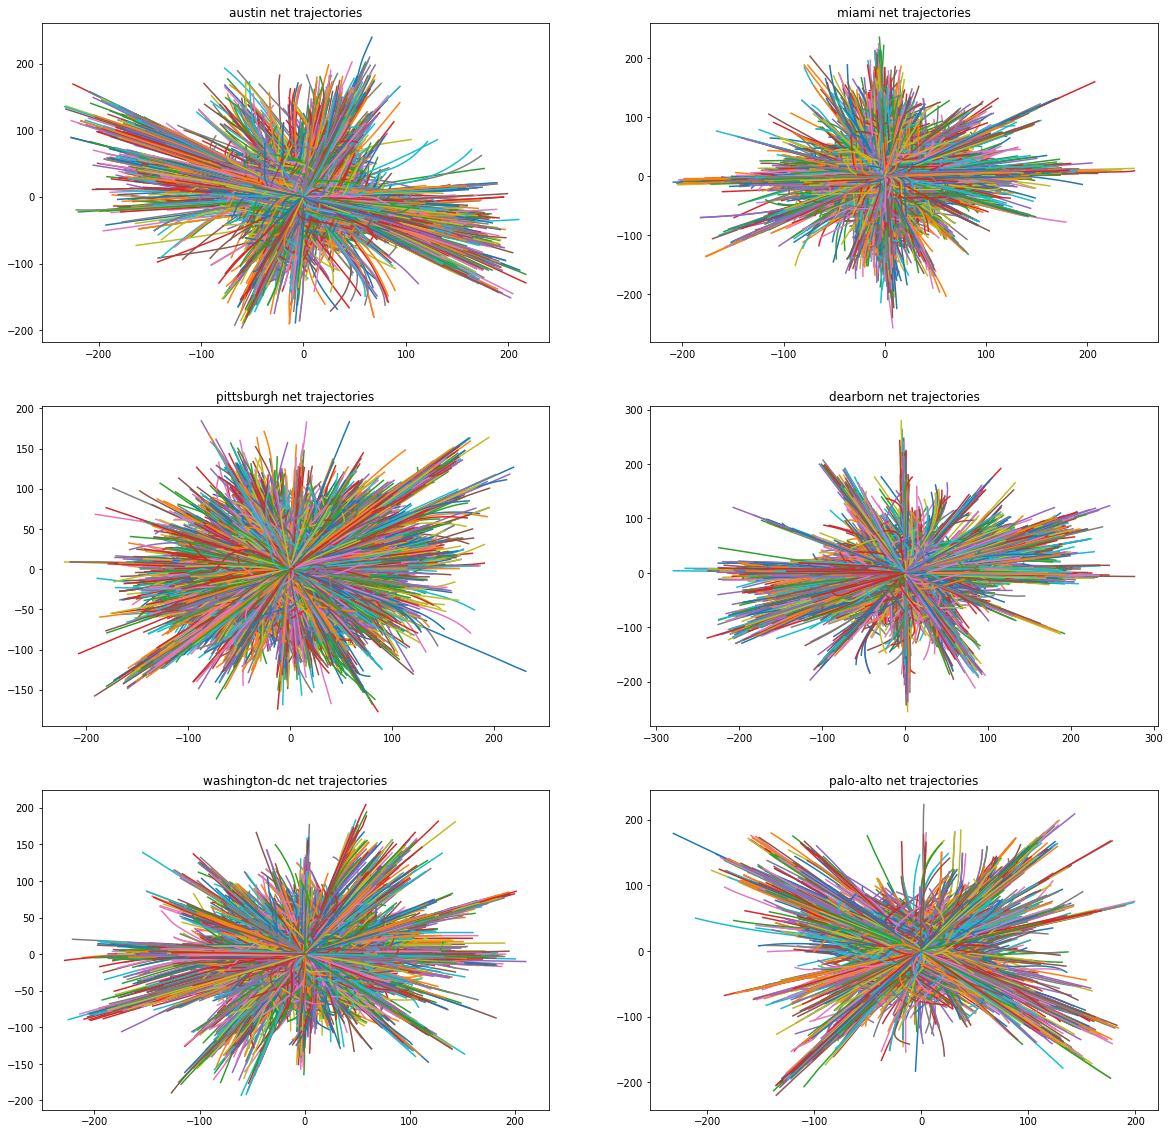

In [13]:
fig7, axs = plt.subplots(nrows=3, ncols=2, figsize=(20,20))

for i in range(len(train_datasets)):
    
    x = i // 2
    y = i % 2
    
    for j in range(train_datasets[i].inputs.shape[0]):
        
        to_plot_input = train_datasets[i].inputs[j,:,:]  
        to_plot_output = train_datasets[i].outputs[j,:,:]
        
        to_plot = np.vstack((to_plot_input, to_plot_output))
        plot_x = to_plot[:,0] - to_plot[:,0][0]
        plot_y = to_plot[:,1] - to_plot[:,1][0]
        
        axs[x][y].plot(plot_x, plot_y)
        axs[x][y].set_title(f'{cities[i]} net trajectories')   

In [22]:
cities

['austin', 'miami', 'pittsburgh', 'dearborn', 'washington-dc', 'palo-alto']

## Create a DataLoader class for training

In [3]:
class ArgoverseDatasetConcat(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, cities:list, split:str, transform=None):
        
        super(ArgoverseDatasetConcat, self).__init__()
        
        self.transform = transform
        self.split = split
        self.inputs, self.outputs = get_city_trajectories(city=cities[0], split=split, normalized=False)
        self.cities = [cities[0]]*len(self.inputs)
        count = 0
        for i in range(len(self.inputs)):
            self.cities[i] = str(count) + '_' + self.cities[i]
            count += 1
        
        for city in cities[1:]:
            city_inputs,city_outputs  = get_city_trajectories(city=city, split=split, normalized=False)
            self.inputs = np.vstack([self.inputs,city_inputs])
            if split != 'test':
                self.outputs = np.vstack([self.outputs,city_outputs])
                
            new_city_labels = [city]*len(city_inputs)
            count = 0
            for i in range(len(city_inputs)):
                new_city_labels[i] = str(count) + '_' + new_city_labels[i]
                count += 1
            self.cities += new_city_labels
         
         #if self.split == 'test':
             #print(self.cities)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        if self.split == 'test':
            return (torch.from_numpy(self.inputs[idx]).float(), self.cities[idx])
        
        data = (torch.from_numpy(self.inputs[idx]).float(), torch.from_numpy(self.outputs[idx]).float(),
                self.cities[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

In [4]:
# initialize concat datasets
train_dataset = ArgoverseDatasetConcat(cities=cities, split='train')
test_dataset = ArgoverseDatasetConcat(cities=cities, split='test')

In [5]:
batch_sz = 100  # batch size 
train_size = int(len(train_dataset)*0.8)
val_size = len(train_dataset) - train_size
               
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])
               
train_loader = DataLoader(train_data, batch_size=batch_sz, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_sz, shuffle=False, drop_last=True)
               
test_loader = DataLoader(test_dataset, batch_size=batch_sz, shuffle=False)


# LR

https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817
https://www.geeksforgeeks.org/training-neural-networks-with-validation-using-pytorch/

In [8]:
class LinearRegression(torch.nn.Module):
    
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(input_size, output_size)
        #self.loss_fn = torch.nn.functional.mse_loss()

    def forward(self, x):
        #print(x.shape)
        #x = x.float()
        out = self.linear(x)
        return out

In [9]:
input_dim = 50
output_dim = 60
learning_rate = 1e-4
num_epochs = 150

model = LinearRegression(input_dim, output_dim)
#model = model.double()

if torch.cuda.is_available():
    model.cuda()

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.01)

In [10]:
validation_losses =[]
train_losses = []

for epoch in tqdm(range(num_epochs), desc='epoch', leave=False):
    
    train_loss_curr = []
    model.train()
    
    for x_train, y_train, cities in tqdm(train_loader, desc='batch', leave=False):
        
        #loss = 0
    
        # Converting inputs and labels to Variable
        if torch.cuda.is_available():
            inputs = x_train.permute(0,2,1).cuda()
            labels = y_train.permute(0,2,1).cuda()
        else:
            inputs = x_train.permute(0,2,1)
            labels = y_train.permute(0,2,1)
            
        

        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()

        # get output from the model, given the inputs
        outputs = model(inputs)
        #print(outputs.shape)

        # get loss for the predicted output
        loss = loss_fn(outputs, labels)
        # get gradients w.r.t to parameters
        loss.backward()
        #print(f'loss: {loss.item()}')
        
        train_loss_curr.append(loss.item())

        # update parameters
        optimizer.step()

    if epoch%10 == 0 and epoch!=0:
        model.eval()

        val_loss_tot = []
        for x_test, y_test, cities in tqdm(val_loader, desc='test_batch', leave=False):

            x_test = x_test.permute(0,2,1)
            y_test = y_test.permute(0,2,1)

            if torch.cuda.is_available():
                x_test, y_test = x_test.cuda(), y_test.cuda()

            prediction = model(x_test)
            valid_loss = loss_fn(prediction, labels)
            val_loss_tot.append(valid_loss.item())
            #print(f'val_loss_tot: {val_loss_tot}')

        avg_val_loss = sum(val_loss_tot)/len(val_loss_tot)
        validation_losses.append(avg_val_loss)

        if len(validation_losses) >= 2 and avg_val_loss < validation_losses[-2]:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses,
                'validation_losses': validation_losses
            }, f'model_{epoch}_best.pt')
            
    if epoch%15 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'validation_losses': validation_losses
        }, f'model_{epoch}_time.pt')

        #break

    train_losses.append(sum(train_loss_curr)/len(train_loss_curr))
    print(f'epoch {epoch}, loss {train_losses[-1]}', end='\r')
    

epoch:   0%|          | 0/150 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

test_batch:   0%|          | 0/407 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

test_batch:   0%|          | 0/407 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

test_batch:   0%|          | 0/407 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

test_batch:   0%|          | 0/407 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

test_batch:   0%|          | 0/407 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

test_batch:   0%|          | 0/407 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

test_batch:   0%|          | 0/407 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

test_batch:   0%|          | 0/407 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

test_batch:   0%|          | 0/407 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

test_batch:   0%|          | 0/407 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

test_batch:   0%|          | 0/407 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

test_batch:   0%|          | 0/407 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

test_batch:   0%|          | 0/407 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

test_batch:   0%|          | 0/407 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

[13144057.818181818, 14095479.656019656, 12486485.184275184, 13581265.375921376, 15312876.547911547, 15713511.113022113, 15115605.395577395, 14056460.398034398, 13724269.449631449, 15887777.685503686, 13523963.965601966, 14763227.614250613, 14951521.997542998, 14215588.815724816]


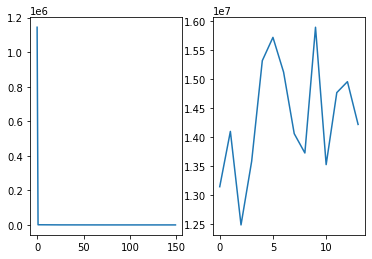

In [11]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.plot(train_losses)
ax2 = fig.add_subplot(122)
ax2.plot(validation_losses)

print(validation_losses)

In [22]:
predictions_test = np.array([])
cities_test = np.array([])

with torch.no_grad(): # we don't need gradients in the testing phase
    predicted = np.array([])
    
    #print(type(test_loader))
    
    for x_test, cities in tqdm(test_loader, desc='test_batch', leave=False):
        
        #print(type(batch))
        
        input_test = torch.from_numpy(np.array(x_test)).permute(0,2,1)
     
        if torch.cuda.is_available():
            input_test = input_test.cuda()
            
        curr_predict = model(input_test)
        #print(curr_predict.shape)
        
    
        if torch.cuda.is_available():
            predicted = curr_predict.cpu().data.numpy()
        else:
            predicted = curr_predict.data.numpy()
        
        #print(predicted.shape)
        if len(predictions_test) == 0:
            predictions_test = predicted
            #cities_test = cities
        else:   
            predictions_test = np.vstack([predictions_test, predicted])
            
        cities_test = np.concatenate([cities_test, cities])

        
print(predictions_test.shape)
print(cities_test.shape)
    
#print(predictions_test[:10])
#print(cities_test[len(cities_test)-10:])

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

(29843, 2, 60)
(29843,)


# RNN

In [6]:
class RNN(nn.Module):
    
    def __init__(self, input_size,  output_size, batch_size, hidden_size=14, n_layers=1):
        super(RNN,self).__init__()
        
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.batch_size = batch_size
        
        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_size, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        hidden = self.init_hidden(x.shape[0])
        if torch.cuda.is_available():
            hidden = hidden.cuda()
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden
        
    def init_hidden(self, size):
        return nn.init.kaiming_uniform_(torch.empty(self.n_layers, size, self.hidden_size))

In [7]:
input_dim = 50
output_dim = 60
learning_rate = 1e-3
num_epochs = 200

model = RNN(input_dim, output_dim, batch_sz, hidden_size=14, n_layers=4)

if torch.cuda.is_available():
    model.cuda()

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.01)

In [8]:
validation_losses =[]
train_losses = []

for epoch in tqdm(range(num_epochs), desc='epoch', leave=False):
    
    train_loss_curr = []
    model.train()
    
    for x_train, y_train, cities in tqdm(train_loader, desc='batch', leave=False):
        
        #loss = 0
    
        # Converting inputs and labels to Variable
        if torch.cuda.is_available():
            inputs = x_train.permute(0,2,1).cuda()
            labels = y_train.permute(0,2,1).cuda()
        else:
            inputs = x_train.permute(0,2,1)
            labels = y_train.permute(0,2,1)
            
        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()

        # get output from the model, given the inputs
        outputs, hidden = model(inputs)
        #print(outputs.shape)

        # get loss for the predicted output
        loss = loss_fn(outputs, labels)
        # get gradients w.r.t to parameters
        loss.backward()
        #print(f'loss: {loss.item()}')
        
        train_loss_curr.append(loss.item())

        # update parameters
        optimizer.step()

    if epoch%10 == 0 and epoch!=0:
        model.eval()

        val_loss_tot = []
        for x_test, y_test, cities in tqdm(val_loader, desc='test_batch', leave=False):

            x_test = x_test.permute(0,2,1)
            y_test = y_test.permute(0,2,1)

            if torch.cuda.is_available():
                x_test, y_test = x_test.cuda(), y_test.cuda()

            prediction, hidden = model(x_test)
            valid_loss = loss_fn(prediction, labels)
            val_loss_tot.append(valid_loss.item())
            #print(f'val_loss_tot: {val_loss_tot}')

        avg_val_loss = sum(val_loss_tot)/len(val_loss_tot)
        validation_losses.append(avg_val_loss)

        print(f'epoch {epoch}, validation loss {validation_losses[-1]}')
        if len(validation_losses) >= 2 and avg_val_loss < validation_losses[-2]:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses,
                'validation_losses': validation_losses
            }, f'model_{epoch}_best.pt')
            
    if epoch%15 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'validation_losses': validation_losses
        }, f'model_{epoch}_time.pt')

        #break

    train_losses.append(sum(train_loss_curr)/len(train_loss_curr))
    print(f'epoch {epoch}, loss {train_losses[-1]}', end='\r')

epoch:   0%|          | 0/200 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

test_batch:   0%|          | 0/407 [00:00<?, ?it/s]

epoch 10, validation loss 9411554.039312039


batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

test_batch:   0%|          | 0/407 [00:00<?, ?it/s]

epoch 20, validation loss 10360152.474201474


batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

test_batch:   0%|          | 0/407 [00:00<?, ?it/s]

epoch 30, validation loss 11237778.164619165


batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

test_batch:   0%|          | 0/407 [00:00<?, ?it/s]

epoch 40, validation loss 9501184.94103194


batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

test_batch:   0%|          | 0/407 [00:00<?, ?it/s]

epoch 50, validation loss 9170730.110565111


batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

test_batch:   0%|          | 0/407 [00:00<?, ?it/s]

epoch 60, validation loss 8825162.496314496


batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

test_batch:   0%|          | 0/407 [00:00<?, ?it/s]

epoch 70, validation loss 10003518.628992628


batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

test_batch:   0%|          | 0/407 [00:00<?, ?it/s]

epoch 80, validation loss 10472354.171990171


batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

test_batch:   0%|          | 0/407 [00:00<?, ?it/s]

epoch 90, validation loss 10606421.673218673


batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

test_batch:   0%|          | 0/407 [00:00<?, ?it/s]

epoch 100, validation loss 11627689.611793611


batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

test_batch:   0%|          | 0/407 [00:00<?, ?it/s]

epoch 110, validation loss 11283809.766584767


batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

test_batch:   0%|          | 0/407 [00:00<?, ?it/s]

epoch 120, validation loss 8615327.66093366


batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

test_batch:   0%|          | 0/407 [00:00<?, ?it/s]

epoch 130, validation loss 7750114.604422605


batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

test_batch:   0%|          | 0/407 [00:00<?, ?it/s]

epoch 140, validation loss 10524366.673218673


batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

test_batch:   0%|          | 0/407 [00:00<?, ?it/s]

epoch 150, validation loss 8959008.294840295


batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

test_batch:   0%|          | 0/407 [00:00<?, ?it/s]

epoch 160, validation loss 9590928.667076167


batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

test_batch:   0%|          | 0/407 [00:00<?, ?it/s]

epoch 170, validation loss 12123173.407862408


batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

test_batch:   0%|          | 0/407 [00:00<?, ?it/s]

epoch 180, validation loss 11140068.167076167


batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

test_batch:   0%|          | 0/407 [00:00<?, ?it/s]

epoch 190, validation loss 8642432.405405406


batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

[9411554.039312039, 10360152.474201474, 11237778.164619165, 9501184.94103194, 9170730.110565111, 8825162.496314496, 10003518.628992628, 10472354.171990171, 10606421.673218673, 11627689.611793611, 11283809.766584767, 8615327.66093366, 7750114.604422605, 10524366.673218673, 8959008.294840295, 9590928.667076167, 12123173.407862408, 11140068.167076167, 8642432.405405406]


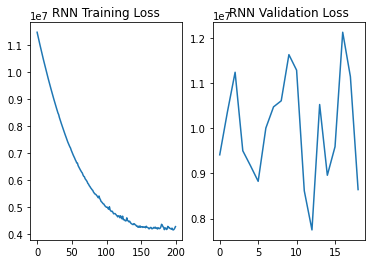

In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.set_title('RNN Training Loss')
ax1.plot(train_losses)
ax2 = fig.add_subplot(122)
ax2.set_title('RNN Validation Loss')
ax2.plot(validation_losses)

print(validation_losses)

In [15]:
predictions_test = np.array([])
cities_test = np.array([])

with torch.no_grad(): # we don't need gradients in the testing phase
    predicted = np.array([])
    
    #print(type(test_loader))
    
    for x_test, cities in tqdm(test_loader, desc='test_batch', leave=False):
        
        #print(type(batch))
        
        input_test = torch.from_numpy(np.array(x_test)).permute(0,2,1)
     
        if torch.cuda.is_available():
            input_test = input_test.cuda()
            
        curr_predict, hidden = model(input_test)
        #print(curr_predict.shape)
        
    
        if torch.cuda.is_available():
            predicted = curr_predict.cpu().data.numpy()
        else:
            predicted = curr_predict.data.numpy()
        
        #print(predicted.shape)
        if len(predictions_test) == 0:
            predictions_test = predicted
            #cities_test = cities
        else:   
            predictions_test = np.vstack([predictions_test, predicted])
            
        cities_test = np.concatenate([cities_test, cities])

        
print(predictions_test.shape)
print(cities_test.shape)
    

test_batch:   0%|          | 0/299 [00:00<?, ?it/s]

(29843, 2, 60)
(29843,)


# LSTM

In [6]:
class LSTM(nn.Module):
    
    def __init__(self, input_size,  output_size, batch_size, hidden_size=14, n_layers=1):
        super(LSTM,self).__init__()
        
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.batch_size = batch_size
        
        #Defining the layers
        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
        # Can add intermediate fc layers too
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h0 = torch.autograd.Variable(torch.zeros(self.n_layers, x.shape[0], self.hidden_size))
        c0 = torch.autograd.Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_size))
        
        if torch.cuda.is_available():
            h0 = h0.cuda()
            c0 = c0.cuda()
            
        out, (h, c) = self.lstm(x, (h0,c0))
        out = self.relu(out)
        out = self.fc(out)
        return out, (h,c)

In [7]:
input_dim = 50
output_dim = 60
learning_rate = 1e-1
num_epochs = 200

model = LSTM(input_dim, output_dim, batch_sz, hidden_size=14, n_layers=1)

if torch.cuda.is_available():
    model.cuda()

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.01)

In [8]:
validation_losses =[]
train_losses = []

for epoch in tqdm(range(num_epochs), desc='epoch', leave=False):
    
    train_loss_curr = []
    model.train()
    
    for x_train, y_train, cities in tqdm(train_loader, desc='batch', leave=False):
        
        #loss = 0
    
        # Converting inputs and labels to Variable
        if torch.cuda.is_available():
            inputs = x_train.permute(0,2,1).cuda()
            labels = y_train.permute(0,2,1).cuda()
        else:
            inputs = x_train.permute(0,2,1)
            labels = y_train.permute(0,2,1)
            
        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()

        # get output from the model, given the inputs
        outputs, hidden = model(inputs)
        #print(outputs.shape)

        # get loss for the predicted output
        loss = loss_fn(outputs, labels)
        # get gradients w.r.t to parameters
        loss.backward()
        #print(f'loss: {loss.item()}')
        
        train_loss_curr.append(loss.item())

        # update parameters
        optimizer.step()

    if epoch%10 == 0 and epoch!=0:
        model.eval()

        val_loss_tot = []
        for x_test, y_test, cities in tqdm(val_loader, desc='test_batch', leave=False):

            x_test = x_test.permute(0,2,1)
            y_test = y_test.permute(0,2,1)

            if torch.cuda.is_available():
                x_test, y_test = x_test.cuda(), y_test.cuda()

            prediction, hidden = model(x_test)
            valid_loss = loss_fn(prediction, labels)
            val_loss_tot.append(valid_loss.item())
            #print(f'val_loss_tot: {val_loss_tot}')

        avg_val_loss = sum(val_loss_tot)/len(val_loss_tot)
        validation_losses.append(avg_val_loss)

        print(f'epoch {epoch}, validation loss {validation_losses[-1]}')
        if len(validation_losses) >= 2 and avg_val_loss < validation_losses[-2]:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses,
                'validation_losses': validation_losses
            }, f'model_{epoch}_best.pt')
            
    if epoch%15 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'validation_losses': validation_losses
        }, f'model_{epoch}_time.pt')

        #break

    train_losses.append(sum(train_loss_curr)/len(train_loss_curr))
    print(f'epoch {epoch}, loss {train_losses[-1]}', end='\r')

epoch:   0%|          | 0/1 [00:00<?, ?it/s]

batch:   0%|          | 0/1630 [00:00<?, ?it/s]

In [9]:
predictions_test = np.array([])
cities_test = np.array([])

with torch.no_grad(): # we don't need gradients in the testing phase
    predicted = np.array([])
    
    #print(type(test_loader))
    
    for x_test, cities in tqdm(test_loader, desc='test_batch', leave=False):
        
        #print(type(batch))
        
        input_test = torch.from_numpy(np.array(x_test)).permute(0,2,1)
     
        if torch.cuda.is_available():
            input_test = input_test.cuda()
            
        curr_predict, hidden = model(input_test)
        #print(curr_predict.shape)
        
    
        if torch.cuda.is_available():
            predicted = curr_predict.cpu().data.numpy()
        else:
            predicted = curr_predict.data.numpy()
        
        #print(predicted.shape)
        if len(predictions_test) == 0:
            predictions_test = predicted
            #cities_test = cities
        else:   
            predictions_test = np.vstack([predictions_test, predicted])
            
        cities_test = np.concatenate([cities_test, cities])

        
print(predictions_test.shape)
print(cities_test.shape)

test_batch:   0%|          | 0/299 [00:00<?, ?it/s]

(29843, 2, 60)
(29843,)


# Velocity Test

In [6]:
cities_test = np.array([])
output_idxs = np.arange(1,61)

predictions_test = []

for x_test, cities in tqdm(test_loader, desc='test_batch', leave=False):

    #print(type(batch))
    #print(x_test[0].shape)
    
    #for i in range(len(x_test)):
        
        #curr_test = x_test[i]
        
    x_test = x_test.numpy()
       
        
    x_start = x_test[:,20,0]
    y_start = x_test[:,20,1]
    x_end = x_test[:,-1,0]
    y_end = x_test[:,-1,1]

    x_velocity = (x_end - x_start)/30
    y_velocity = (y_end - y_start)/30

    curr_val_x = x_end
    curr_val_y = y_end

    predicted_x = [(x_end + (x_velocity*i)) for i in range(60)]
    predicted_y = [(y_end + (y_velocity*i)) for i in range(60)]
    
    predicted_x = np.array(predicted_x).T
    predicted_y = np.array(predicted_y).T
    
    predicted_coordinates = np.stack([predicted_x,predicted_y],axis=1)
    #print(predicted_coordinates.shape)
    
    predictions_test.append(predicted_coordinates)
    
predictions_test = np.concatenate(predictions_test,axis=0)
print(predictions_test.shape)

    #for i in range(60):

#         if len(predicted_x) == 0:
#             predicted_x = curr_val_x + x_velocity
#             predicted_y = curr_val_y + y_velocity
#         else:
#             predicted_x = np.hstack([predicted_x, curr_val_x + x_velocity])
#             predicted_y = np.hstack([predicted_y, curr_val_y + y_velocity])

                
# predicted_x = np.array(predicted_x).T
# predicted_x.shape

test_batch:   0%|          | 0/299 [00:00<?, ?it/s]

(29843, 2, 60)


# Output Results to File

In [7]:
dtypes = {'ID':str}
for i in range(120):
    dtypes['v'+str(i)] = np.float32

In [8]:
trajectory_table = pd.read_csv('sample_submission.csv', dtype=dtypes)
#trajectory_table = trajectory_table.astype(np.float32)
trajectory_table.head()

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1_austin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2_austin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3_austin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4_austin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
trajectory_table.tail()

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
29838,1681_palo-alto,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29839,1682_palo-alto,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29840,1683_palo-alto,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29841,1684_palo-alto,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29842,1685_palo-alto,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
for i in range(len(predictions_test)):
    
    curr_col = 0
    traj_pred = predictions_test[i]
    
    for j in range(traj_pred.shape[1]):
        col1 = 'v'+str(curr_col)
        col2 = 'v'+str(curr_col+1)
        
        trajectory_table.at[i, col1] = np.float64(traj_pred[0][j])
        trajectory_table.at[i, col2] = np.float64(traj_pred[1][j])
        curr_col += 2
    #break

In [11]:
trajectory_table.head()

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,-11.649155,-567.496704,-12.439878,-567.244141,-13.230602,-566.991577,-14.021325,-566.739014,-14.812049,...,-55.138950,-553.605347,-55.929672,-553.352783,-56.720398,-553.100220,-57.511120,-552.847656,-58.301846,-552.595093
1,1_austin,-345.227600,12.296963,-345.148132,11.756042,-345.068695,11.215120,-344.989227,10.674199,-344.909760,...,-340.857361,-17.453701,-340.777924,-17.994621,-340.698456,-18.535543,-340.618988,-19.076464,-340.539551,-19.617386
2,2_austin,50.986946,-247.669159,50.986416,-247.670227,50.985886,-247.671310,50.985359,-247.672379,50.984829,...,50.957817,-247.728180,50.957287,-247.729263,50.956760,-247.730331,50.956230,-247.731400,50.955700,-247.732483
3,3_austin,-113.813309,1798.151123,-113.793579,1798.273315,-113.773842,1798.395630,-113.754105,1798.517822,-113.734375,...,-112.727966,1804.874390,-112.708237,1804.996582,-112.688507,1805.118896,-112.668770,1805.241089,-112.649033,1805.363403
4,4_austin,1194.694946,-637.518005,1195.724487,-637.937988,1196.754028,-638.358032,1197.783569,-638.778015,1198.813110,...,1251.320312,-660.618652,1252.349976,-661.038635,1253.379517,-661.458679,1254.409058,-661.878662,1255.438599,-662.298706


In [12]:
trajectory_table.to_csv('submission_test.csv', index=False)

## Sample a batch of data and visualize 

torch.Size([100, 2, 60])


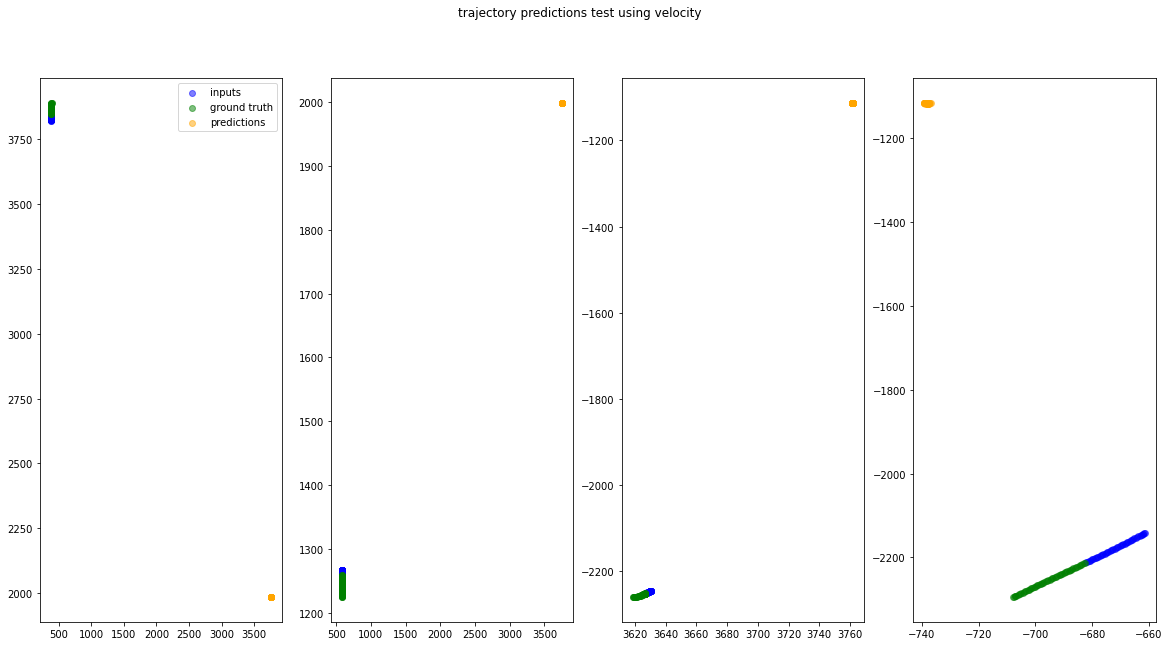

In [20]:
model.eval()
for x_train, y_train, cities in train_loader:
    
    if torch.cuda.is_available():
        inputs = x_train.permute(0,2,1).cuda()
        labels = y_train.permute(0,2,1).cuda()
    else:
        inputs = x_train.permute(0,2,1)
        labels = y_train.permute(0,2,1)
        
    outputs, h = model(inputs)
    
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,10))
    
    print(labels.shape)
    
    for i in range(4):
            
        curr_inputs_x = inputs[i][0].cpu()
        curr_inputs_y = inputs[i][1].cpu()
        
        curr_labels_x = labels[i][0].cpu()
        curr_labels_y = labels[i][1].cpu()
        
        curr_pred_x = outputs[i][0].cpu()
        curr_pred_y = outputs[i][1].cpu()
        
        axs[i].scatter(curr_inputs_x, curr_inputs_y, alpha=0.5, c='b', label='inputs')
        axs[i].scatter(curr_labels_x, curr_labels_y, alpha=0.5, c='g', label='ground truth')
        axs[i].scatter(curr_pred_x.detach(), curr_pred_y.detach(), alpha=0.5, c='orange', label='predictions')
    
    fig.suptitle('trajectory predictions test using rnn')
    axs[0].legend()
    
    #print(batch[0])
    break

test_batch:   0%|          | 0/1630 [00:00<?, ?it/s]

torch.Size([100, 50, 2])


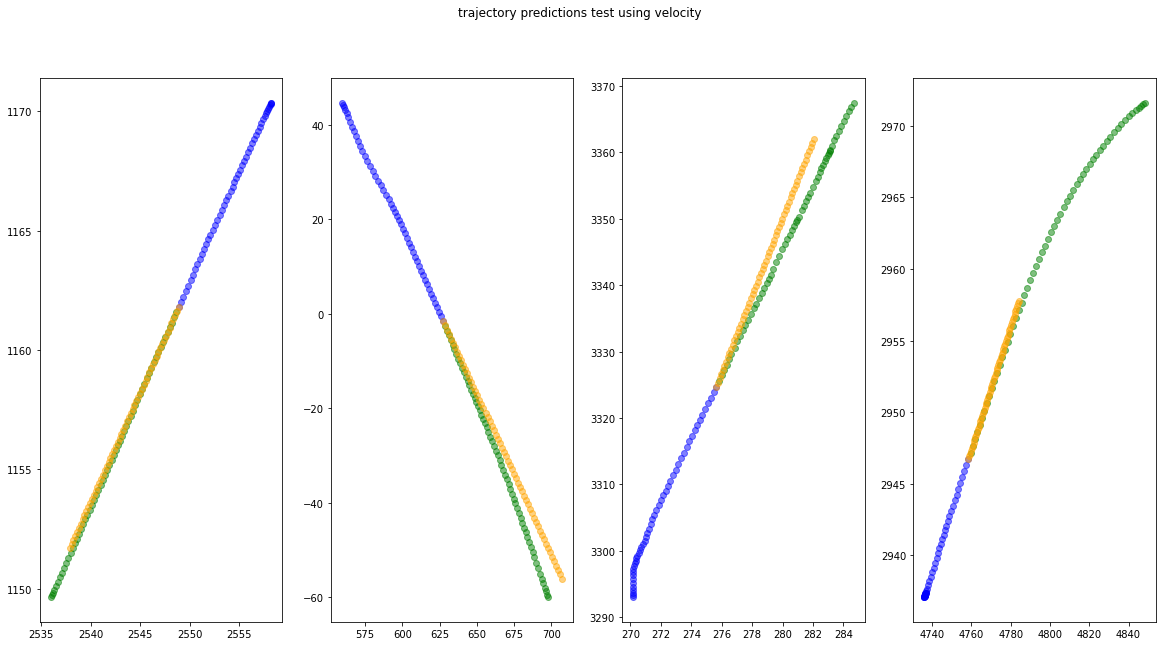

In [34]:
for x_train, y_train, cities in tqdm(train_loader, desc='test_batch', leave=False):
    
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,10))
    
    print(x_train.shape)
    
    for i in range(4):
        
        x_test = x_train[i]
        #print(x_test[0])
        x_test = x_test.numpy()
        y_curr = y_train[i].numpy()
        #print(y_curr[0])
        #print(f'x test shape: {x_test.shape}')
        #print(f'y curr shape: {y_curr.shape}')
       
        x_start = x_test[0][0]
        y_start = x_test[0][1]
        x_end = x_test[-1][0]
        y_end = x_test[-1][1]

        x_velocity = (x_end - x_start)/50
        y_velocity = (y_end - y_start)/50


        predicted_x = [(x_end + (x_velocity*i)) for i in range(60)]
        predicted_y = [(y_end + (y_velocity*i)) for i in range(60)]

        predicted_x = np.array(predicted_x).T
        predicted_y = np.array(predicted_y).T

        predicted_coordinates = np.stack([predicted_x,predicted_y],axis=1)
        #print(f'pred shape: {predicted_coordinates.shape}')
        
        axs[i].scatter(x_test[:,0], x_test[:,1], alpha=0.5, c='b', label='inputs')
        axs[i].scatter(y_curr[:,0], y_curr[:,1], alpha=0.5, c='g', label='ground truth')
        axs[i].scatter(predicted_coordinates[:,0], predicted_coordinates[:,1], alpha=0.5, c='orange', label='predictions')
        
    fig.suptitle('trajectory predictions test using velocity')
    break
        

In [ ]:
fig8, axs = plt.subplots(nrows=sample_size, ncols=2, figsize=(10,sample_size*5))

for i in range(sample_size):
    # plot actual trajectory
    x = i
    y = 0
    
    to_plot_input = sample_data[i][0]#.inputs[j,:,:]
    to_plot_output = sample_data[i][1]#.outputs[j,:,:]
    plot_x_input = to_plot_input[:,0]
    plot_y_input = to_plot_input[:,1]
    plot_x_output = to_plot_output[:,0]
    plot_y_output = to_plot_output[:,1]

    axs[x][y].plot(plot_x_input, plot_y_input)
    axs[x][y].plot(plot_x_output, plot_y_output)
    axs[x][y].set_title(f'{sample_data[i][2]} actual sample trajectory')
    
    # plot predicted trajectory
    y += 1
    to_plot_input = sample_data[i][0]#.inputs[j,:,:]  
    to_plot_output = predictions_test[i]#.outputs[j,:,:]
    plot_x_input = to_plot_input[:,0]
    plot_y_input = to_plot_input[:,1]
    plot_x_output = to_plot_output[0]
    plot_y_output = to_plot_output[1]

    axs[x][y].plot(plot_x_input, plot_y_input)
    axs[x][y].plot(plot_x_output, plot_y_output)
    axs[x][y].set_title(f'{sample_data[i][2]} predicted trajectory')

# Defining and Training an RNN

In [ ]:
# class Net(nn.Module):
#     def __init__(self, input_size, output_size, hidden_size, num_layers=1, nonlinearity=tanh, dropout=False):
        
#         self.input_size = input_size
#         self.output_size = output_size
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
        
#         super(Net, self).__init__()
        
#         # RNN layer
#         self.rnn = nn.RNN(input_size, hidden_dim, n_layers=n_layers, batch_first=True)
        
#         # fully connected output
#         self.fc = nn.Linear(hidden_dim, output_size)
        